### Work and Health
1. Importing the data
    1. Functions to filter & clean the data
2. Pre-process the data
    1. Exploration
    2. Feature Engineering
    3. Missing Values
    . Outliers
4. In depth-exploration
5. Cluter Analysis
    1. Transform the data
    2. Check for optimal K
    3. Apply K-means and interpret results
  

In [1]:
#Import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor
plt.style.use('ggplot')
#C:\Users\lsove\OneDrive\Documentos

### Brief summary of the data-sets

In [2]:
summary_df = pd.read_excel('../raw data/Data_set_desc.xlsx')

In [82]:
list(summary_df.description[summary_df.index ==1])

['Total weekly hours worked of employed persons (thousands)']

### Import diseases data

In [6]:
df_diseases_1 = pd.read_csv('../raw data/Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-1/IHME-GBD_2019_DATA-16b07a3d-1.csv')
df_diseases_2 = pd.read_csv('../raw data//Diseases_GHDx_2/IHME-GBD_2019_DATA-16b07a3d-2/IHME-GBD_2019_DATA-16b07a3d-2.csv')
df_diseases = df_diseases_1.append(df_diseases_2).reset_index()
df_diseases.drop(columns = 'index', inplace = True)

### Function to filter usefull disease data

In [7]:
#data cleaning - function that receives year of analysis, gender, metric and measure. Returns the "cleaned" df

def get_df_dis(df,year,gender,metric,measure):
    
    year = int(year)
    
    #drop redundant columns (code for each feature, mainly)
    df.copy().drop(columns=['measure_id','location_id','measure_name','sex_id','age_id','age_name','cause_id','metric_id'\
                         ,'upper','lower'], inplace=True)
    
    #filter by gender and year (Male or Female)
    df = df.loc[df_diseases['sex_name'].isin([gender])]\
.loc[df_diseases['year'] == year].drop(columns=['sex_name','year']).copy()
    
    #filter by metric (Number, Percent or Rate)
    df = df.loc[df.metric_name == metric].copy()
    df.drop(columns = ['metric_name'],inplace = True)
    
    #filter by measure (Incidence or Prevalence)
    df = df.loc[df.measure_name == measure].copy()
    df.drop(columns = ['measure_name'],inplace = True)
    
    #pivoting table with disease names = columns
    df = df.copy().pivot(index='location_name', columns = 'cause_name', values = 'val')
    
    df.drop(columns = ['Stroke','Headache disorders'],inplace = True)
    
    df.rename(columns={'Anxiety disorders':'Anxiety_disorder','Bipolar disorder':'Bipolar_disorder',\
                      'Depressive disorders':'Depressive_disorders','Musculoskeletal disorders':\
                      'Musculoskeletal_disorders'}, inplace=True)
    
    return df

### Import health cost data

In [8]:
df_health_cost = pd.read_excel('../raw data/Health_expenditure_WB/Health_expenditure_WB.xls',na_values='..')

### Function to filter usefull HC data

In [9]:
def get_df_hc(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SH.XPD.GHED.PP.CD':'Public_cost','SH.XPD.PVTD.PP.CD':'Private_cost'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Import GDP p/capita data

In [10]:
df_gdp = pd.read_excel('../raw data/GPD_WB/GPD_CAPITA_WB.xlsx',na_values='..')

### Function to filter usefull GDP data

In [11]:
def get_gdp(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'NY.GDP.PCAP.CD':'GDP_PC'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Import Employment data

In [12]:
df_employment = pd.read_excel('../raw data/Employment_WB_2/Employment_WB_2.xlsx',na_values='..')

### Function to filter usefull employment data

In [13]:
def get_employment(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename columns for better readability
    df.rename(columns={'SL.AGR.EMPL.FE.ZS':'per_female_agriculture',\
                      'SL.AGR.EMPL.MA.ZS':'per_male_agriculture',\
                      'SL.AGR.EMPL.ZS':'per_total_agriculture',\
                      'SL.EMP.TOTL.SP.ZS':'per_total_employment',\
                      'SL.EMP.TOTL.SP.MA.ZS':'per_male_employment',\
                      'SL.EMP.TOTL.SP.FE.ZS':'per_female_employment',\
                      'SL.IND.EMPL.FE.ZS':'per_female_industry',\
                      'SL.IND.EMPL.MA.ZS':'per_male_industry',\
                      'SL.IND.EMPL.ZS':'per_total_industry',\
                      'SL.SRV.EMPL.FE.ZS':'per_female_services',\
                      'SL.SRV.EMPL.MA.ZS':'per_male_services',\
                      'SL.SRV.EMPL.ZS':'per_total_services'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Unemployment & Labor force data

In [14]:
df_unemp_lforce = pd.read_excel('../raw data/UNEMP_LABORFORCE/unemp_lforce.xlsx',na_values='..')

In [15]:
def get_unemp_lforce(df,year):
        #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SL.TLF.CACT.ZS':'Total_Labor_Force', 'SL.UEM.TOTL.ZS':'Unemployment_rate'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    return df

### Hours worked

In [16]:
df_hours_work = pd.read_excel('../raw data/HOURS_ILO/HOURS_ILO.xlsx',na_values='..')

In [17]:
def get_hours_work(df,year):
    
    year = int(year)
        
    # remove unnecessary years
    df = df[['ref_area.label','obs_value']].loc[df.time == year].copy()
    
    df.set_index('ref_area.label', inplace = True)
    
    df = df.rename_axis('location_name')
        
    df.rename(columns={'obs_value':'Weekly_work_hours'}, inplace = True)
    
    df['Weekly_work_hours'] =  df['Weekly_work_hours']*1000
    
    return df

### Population size

In [18]:
df_pop = pd.read_excel('../raw data/Population/Population.xlsx',na_values='..')

In [19]:
def get_pop(df,year):
    
    #transform column names into more readable names
    new_col = list(df.columns)[0:4]
    for col in list(df.columns)[4::]:
        new_col.append(col.split(' ')[0])
    
    #reassign years as new columns
    df.set_axis(new_col, axis=1, inplace=True)
        
    # remove unnecessary years
    df = df[['Series Code','Country Name',year]].copy()
    
    #pivoting the table 
    df = df.copy().pivot(index='Country Name', columns = 'Series Code', values = year)
    
    #rename series columns for more readability
    df.rename(columns={'SP.POP.0014.TO':'Pop_Under15','SP.POP.TOTL':'Pop_Total'}, inplace=True)
    
    #rename index axis for further merging
    df = df.rename_axis('location_name')
    
    df['Pop_Over15'] = (df['Pop_Total']-df['Pop_Under15'])
    
    df.drop(columns =['Pop_Total','Pop_Under15'],inplace = True)
    
    return df

### SUMMARY OF ALL DATA GATHERED

### Function to merge all data frames depending on the year

In [102]:
# Getting all filtered df's
def merge2complete (year):
    
    df1 = get_df_dis(df_diseases,year,'Both','Rate','Incidence')
    df2 = get_df_hc(df_health_cost,year)
    df3 = get_gdp(df_gdp,year)
    df4 = get_employment(df_employment,year)
    df5 = get_unemp_lforce(df_unemp_lforce,year)
    df6 = get_hours_work(df_hours_work,year)
    df7 = get_pop(df_pop,year)
    
    #merge with inner join on the location

    df8 = pd.merge(df1,df2, on='location_name', how='inner')
    df9 = pd.merge(df8,df3, on='location_name', how='inner')
    df10 = pd.merge(df9,df4, on='location_name', how='inner')
    df11 = pd.merge(df10,df5, on='location_name', how='inner')
    df12 = pd.merge(df11,df6, on='location_name', how='inner')
    df13 = pd.merge(df12,df7, on='location_name', how='inner')

    #remove gender related columns:
    col_remove = ['per_female_agriculture','per_male_agriculture','per_male_employment','per_female_employment',\
                 'per_female_industry','per_male_industry','per_female_services','per_male_services']
    complete = df13.drop(columns = col_remove)
    
    return complete

### Evaluate Outliers

In [103]:
def eval_outliers(df,columns):
    # check distribution of feature with highest kurtosis/skewness
    fig, axes = plt.subplots(1,len(columns), figsize = (14,6))
    for i,col_name in enumerate(columns):
        sns.boxplot(ax = axes[i], data = df, x = col_name).set(title=col_name)
    plt.show()
    
    return pd.DataFrame({'skew':df.skew(),'kurt':df.kurt()})

### Missing Values

In [104]:
def predict_missing(df, evaluated_column):
    """ Predicts and updates the missing values for the different features. """
    
    cols = list(df.isna().sum()[df.isna().sum() != 0].index)
    
    # removes the evaluated feature
    cols.remove(evaluated_column)
    
    # defines the data to be used using the gradiant boosting method
    gb_data = df.select_dtypes(exclude=['object']).drop(columns = cols)
    
    # divides the data in missing and complete values
    feature_na = gb_data.loc[gb_data[evaluated_column].isna()]
    feature = gb_data.loc[~gb_data[evaluated_column].isna()]
    
    # defines the training data
    x_train = feature.drop(columns = evaluated_column)
    y_train = feature.copy().pop(evaluated_column)
    
    # fits the model
    gb = GradientBoostingRegressor(n_estimators=100)
    gb.fit(x_train, y_train)
    
    # predicts missing values
    x_predict = feature_na.drop(columns = evaluated_column)
    pred = pd.DataFrame(gb.predict(x_predict), index=x_predict.index, columns=[f'{evaluated_column}_na'])
    
    # fills the na values
    df = df.merge(pred, left_index=True, right_index=True, how='left')
    df.loc[df[evaluated_column].isna(), evaluated_column] = df[f'{evaluated_column}_na']
    df.drop(columns = [f'{evaluated_column}_na'], inplace=True)
    
    return df

### Feature Engineering

In [138]:
def feature_df(df,year):
    
 #group all mental disordes in new variable
    df['mental_disorders'] = df['Anxiety_disorder']+df['Bipolar_disorder']+df['Depressive_disorders']
    
    #group all costs in one single cost variable
    df['total_health_cost']=df['Private_cost']+df['Public_cost']
    
    #group all diseases in single total diseases var
    df['all_disorders'] = df['mental_disorders']+df['Musculoskeletal_disorders']+df['Dermatitis']
    
    #normalize variables PER CAPITA
    #per_total_employment: Employment to population ratio, 15+, total (%)
    #per_total_sector: Employment in each sector (% of total employment)
    
    #df['agriculture_PC'] = (df['per_total_employment']*df['per_total_agriculture'])/10000
    #df['industry_PC'] = (df['per_total_employment']*df['per_total_industry'])/10000
    #df['services_PC'] = (df['per_total_employment']*df['per_total_services'])/10000
    
    #unemployment is per total work force & labor force is per capita.
    df['Unemp_PC'] = (df['Unemployment_rate']*df['Total_Labor_Force'])/10000
    
    
    df['Week_hours_PC'] = df['Weekly_work_hours']/(df['Pop_Over15']*(df['per_total_employment'])/100)
    
    #df.drop(columns=['Anxiety_disorder','Bipolar_disorder','Depressive_disorders',\
    #                 'Public_cost','Private_cost','per_total_agriculture',\
    #                'per_total_industry','per_total_services',\
    #                'Total_Labor_Force','Unemployment_rate'],inplace=True)
    
    df.drop(columns=['Weekly_work_hours','Pop_Over15','Anxiety_disorder','Bipolar_disorder','Depressive_disorders',\
                     'Public_cost','Private_cost',\
                    'Total_Labor_Force','Unemployment_rate'],inplace=True)
    
    
    #correlation map
    sns.set(font_scale=1.3)
    df_corr = df.corr(method = 'spearman')
    figure = plt.figure(figsize=(20,15))
    sns.heatmap(df_corr, annot=True, fmt = '.1g').set(title=year)
    plt.show()
    
    return df

### Clustering:
1. evaluate correlations
2. evaluate normality & apply transformations
3. evaluate K
4. evaluate clusters, knowing K

In [173]:
def eval_corr (df,columns):
    temp = df[columns]
    
    #correlation heatmap:
    sns.set(font_scale=1.3)
    df_corr = temp.corr(method = 'spearman')
    figure = plt.figure(figsize=(20,15))
    sns.heatmap(df_corr, annot=True, fmt = '.1g')
    
    #pairplots:
    sns.pairplot(df[columns])
    
    plt.show()    

In [25]:
def pt_evaluation(df, evaluated_column):
    """ Evaluates the defined feature before and after applying power transformation. """
    
    # defining the power transformation class
    pt = PowerTransformer()

    # creating the evaluation data frame
    feature = df[[evaluated_column]]
    feature = feature.assign(log_transformation = np.log(feature[evaluated_column] + 1))
    feature = feature.assign(sqrt_transformation = np.sqrt(feature[evaluated_column]))
    feature = feature.assign(cbrt_transformation = np.cbrt(feature[evaluated_column]))
    #feature = feature.assign(yeo_johnson = pt.fit_transform(np.array(feature[evaluated_column]).reshape(-1, 1)))
    
    # represent the data
    fig, axes = plt.subplots(1, 4, figsize=(25, 6))
    sns.histplot(data=feature, x=evaluated_column,  ax=axes[0])
    sns.histplot(data=feature, x='sqrt_transformation', ax=axes[1], legend=False)
    sns.histplot(data=feature, x='cbrt_transformation', ax=axes[2], legend=False)
    sns.histplot(data=feature, x='log_transformation', ax=axes[3], legend=False)
    #sns.histplot(data=feature, x='yeo_johnson', ax=axes[4], legend=False)

In [26]:
def evaluate_number_clusters(df, n):
    """ Evaluates the kmeans using different values of k. """
    
    # evalaution result list
    evaluation = []
    
    # evaluates different number of clusters
    for k in range(2, n):    

        # performs the kmeans cluster using the defined number of clusters
        kmeans = KMeans(n_clusters=k, random_state=0).fit(df)
        silhoutte_score = silhouette_score(df, kmeans.labels_)

        # appends the results to the 
        evaluation.append([k, kmeans.inertia_, silhoutte_score])

    # converts the evaluation do df
    evaluation = pd.DataFrame(evaluation, columns=['k', 'error', 'silhouette'])

    # plots the evaluation
    fig, axes = plt.subplots(2,1, figsize = (14,6))
    sns.lineplot(data=evaluation, x='k', y='error', ax=axes[0], markers=True, marker="o")
    sns.lineplot(data=evaluation, x='k', y='silhouette', ax=axes[1], markers=True, marker="o")
    
    # saves the evaluation
    #fig.savefig(f'{prefix}_number_of_clusters_evaluation.png')

In [208]:
def evaluate_cluster(df_cluster, df_evaluate, k):
    """ Evaluate a specific number of cluster. """ 
    
    # applies the kmeans with specific number of clusters
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_cluster)
    labels = kmeans.labels_
    
    # updates the cluster data
    df_cluster = df_cluster.assign(cluster = labels)
    
    # defines the number of columns to be evaluated
    columns = df_cluster.columns[:-1]
    n_columns = len(columns)
    
    # defines the standard height and width of the graphs
    graph_height = 6
    praph_width = 6
    
    # defines the number of columns and rows to be ploted
    n_columns_subplot = n_columns if n_columns <= 3 else 3
    if n_columns // 3 == 0 and n_columns != 3:
         n_rows_subplot = 1
    elif n_columns // 3 != 0 and n_columns % 3 == 0:
        n_rows_subplot = n_columns // 3 
    else:
        n_rows_subplot = n_columns // 3 + 1

    # calculates the total heigh and width
    total_height = graph_height * n_rows_subplot
    total_width = praph_width * n_columns_subplot
    
    # creates the subplot structure
    fig, axes = plt.subplots(n_rows_subplot, n_columns_subplot, figsize=(total_width, total_height))
    
    # defines the initial axis location of the plots
    if n_rows_subplot == 1:
        p = 0
    else:
        r = 0
        c = 0
    
    # plots all the columns
    for column in columns:
        if n_rows_subplot == 1:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[p], fill=True)
            p += 1
        else:
            sns.kdeplot(data=df_cluster, x=column, hue='cluster', ax=axes[r, c], fill=True)
            if c == n_columns_subplot-1:
                r += 1
                c = 0
            else:
                c += 1
            
    # saves the plot
    
    # shows the plot
    plt.show()
    
    # updates the evalutiaon data
    df_evaluate = df_evaluate.assign(labels=kmeans.labels_)
    
    # defines the evalaution metrics for each cluster
    metrics = {'labels': 'count'}
    for column in df_evaluate.columns:
        if column != 'labels':
            metrics[column] = ['mean', 'median']
    df_evaluate.groupby('labels').agg(metrics).round(2)
    
    return df_evaluate

## Analysis for 2017


In [139]:
df_17 = merge2complete('2017')

### Basic Exploration

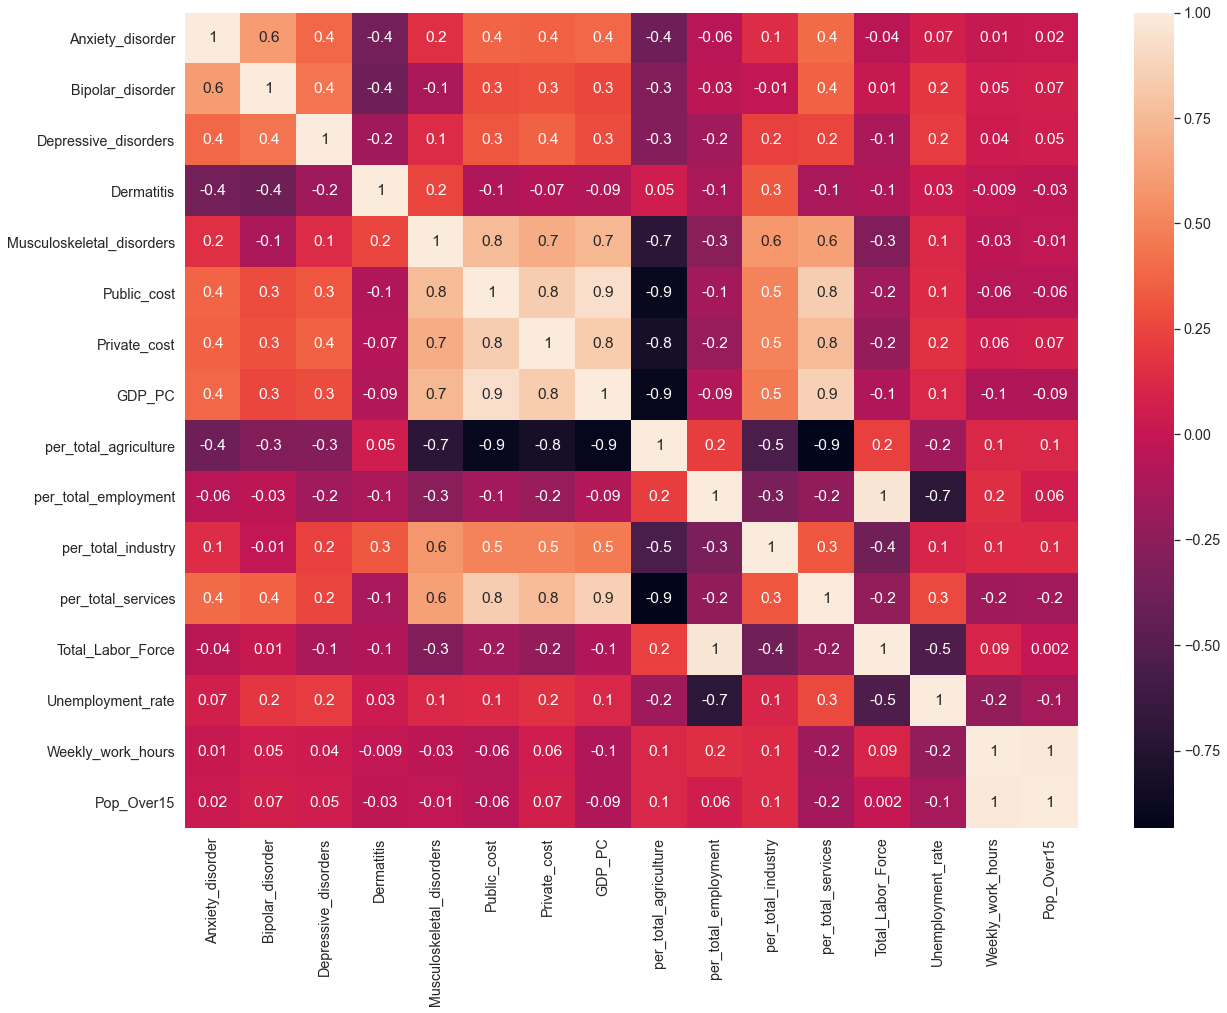

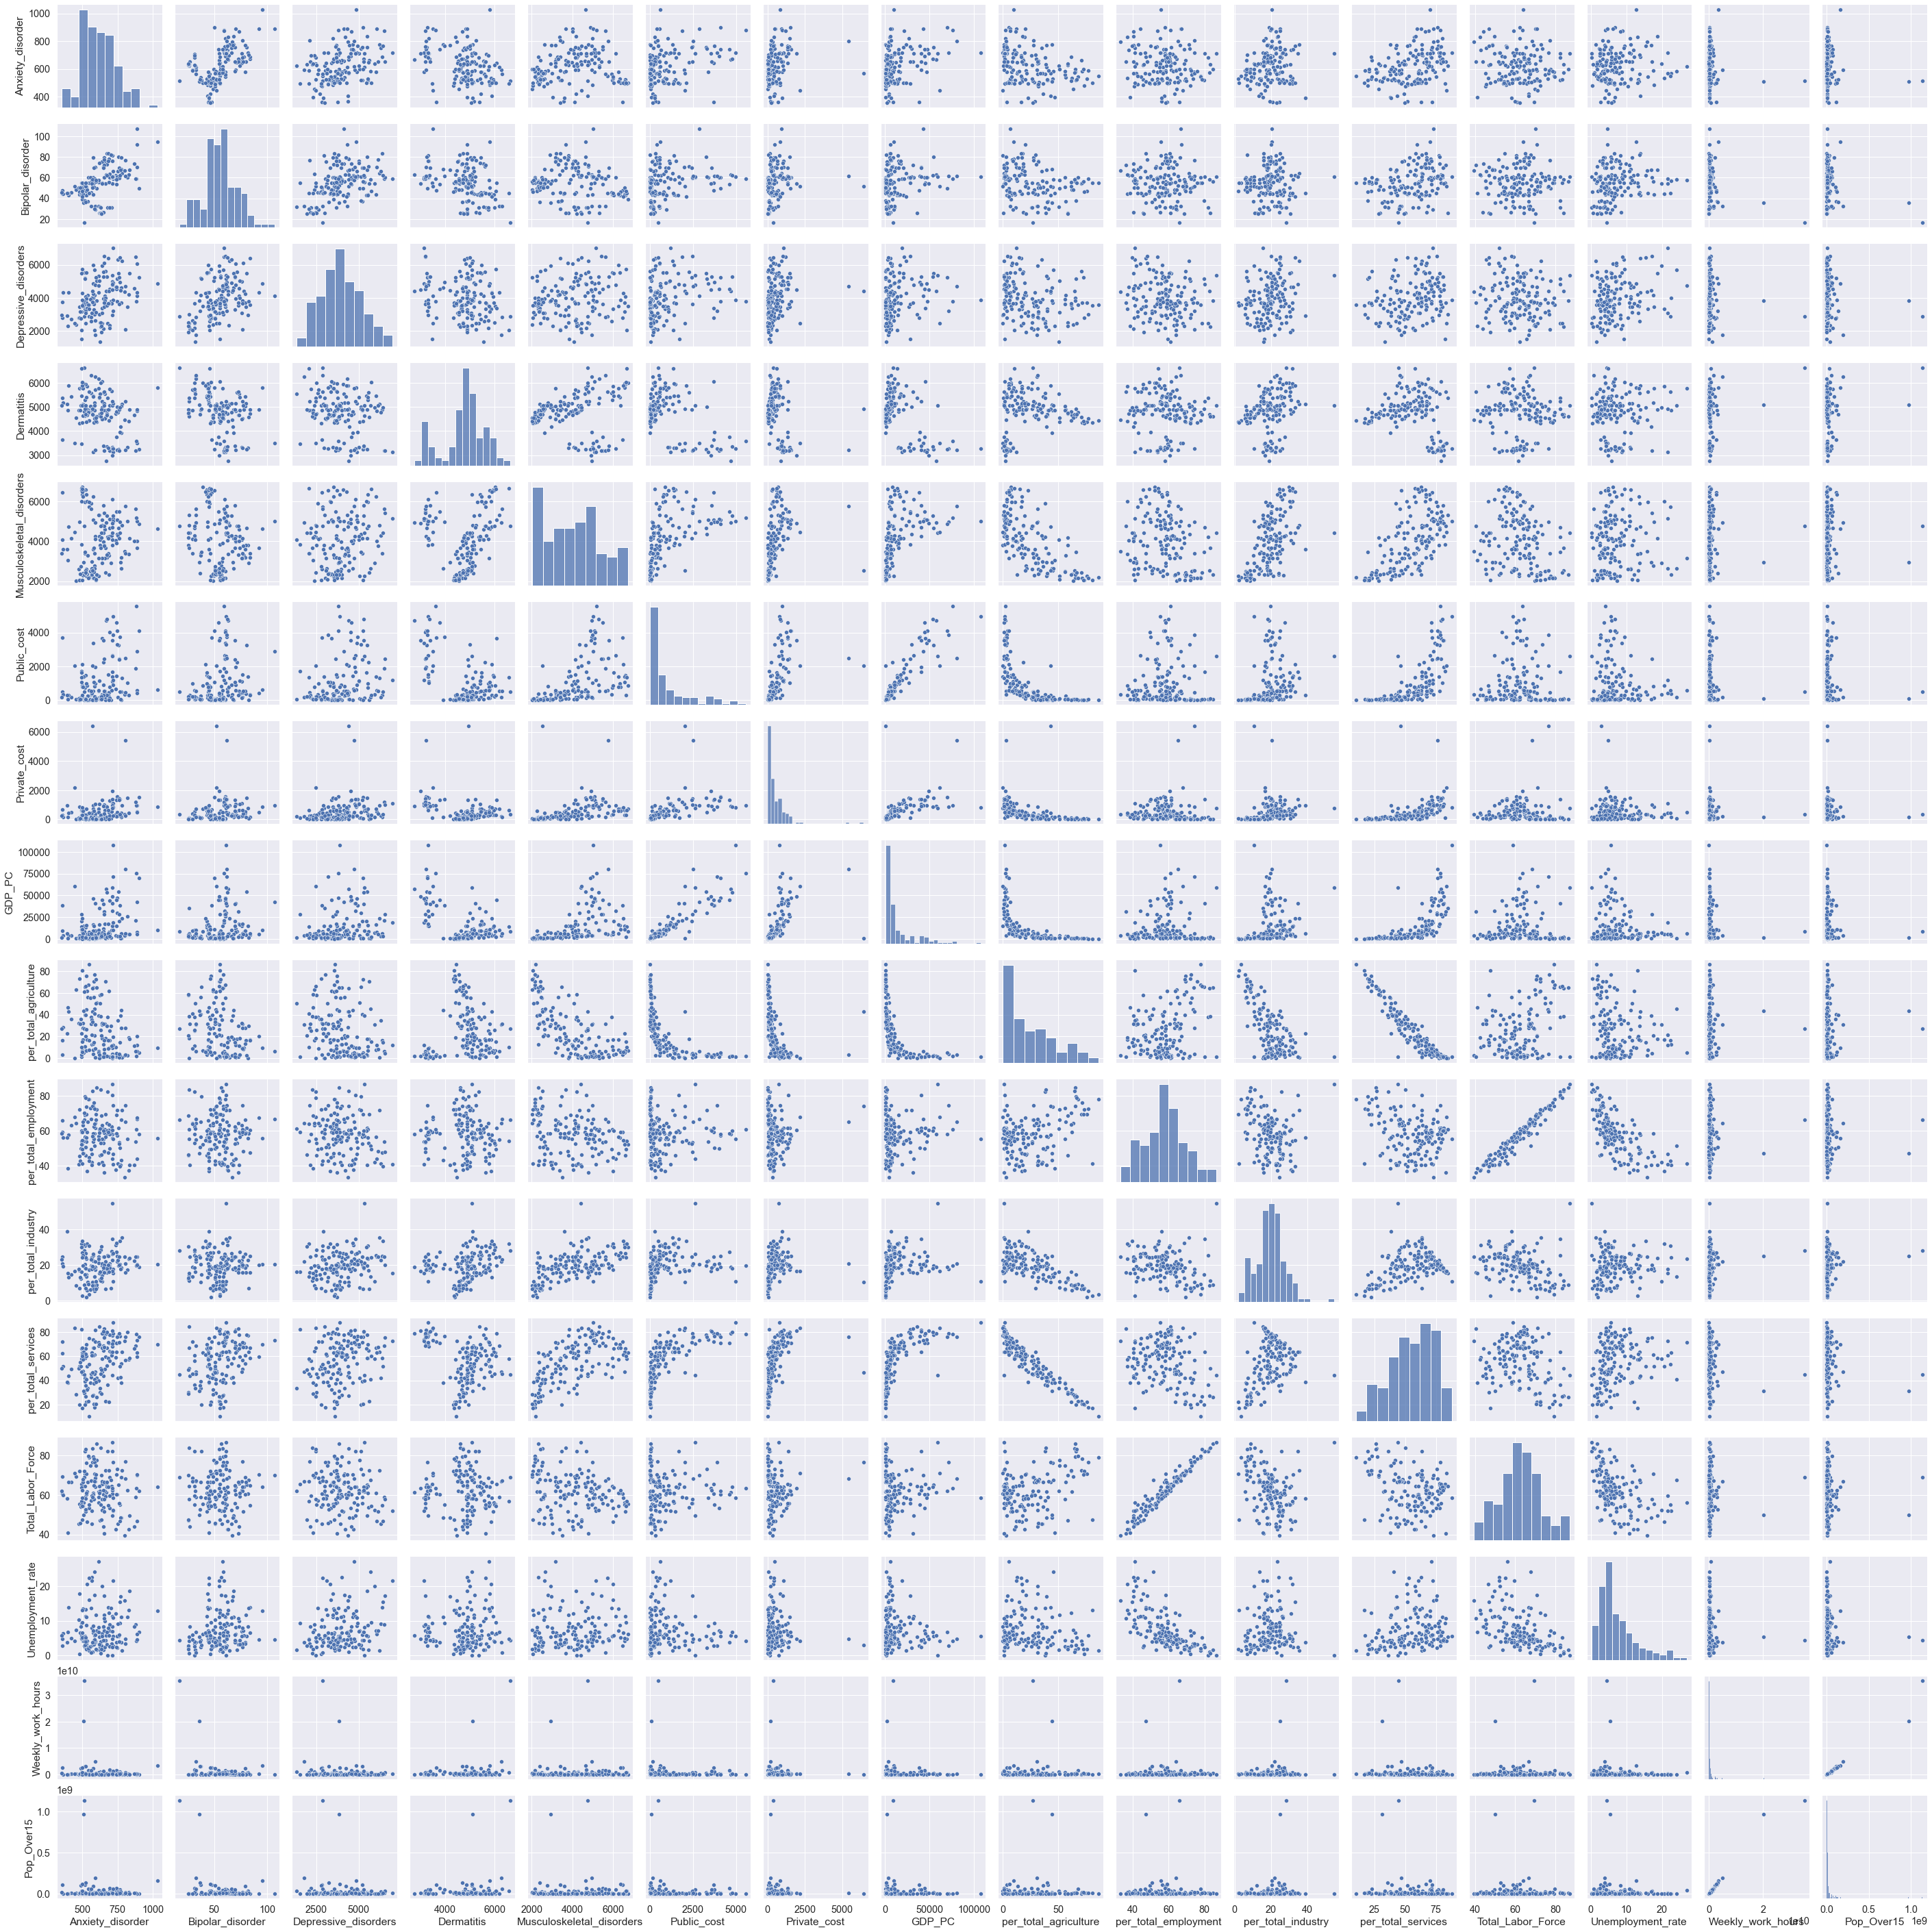

In [140]:
evaluate_features(df_17,list(df_17.columns))

### Interesting correlations:
	
* Musc. Disorders & GDP_PC -> 0,7
* Musc. Disorders & Public_Cost -> 0,8
* Musc. Disorders & Private_Cost -> 0,7
* Musc. Disorders & per_total_agric -> -0,7
	
* Public_Cost & per_total_services -> 0,8
* Public_Cost & per_total_agriculture -> -0,9
* Public_Cost & GDP_PC -> 0,9
* Public_Cost & Private_Cost -> 0,8
	
* Private_Cost & per_total_services -> 0,8
* Private_Cost & per_total_agriculture -> -0,8
* Private_cost & GDP_PC -> 0,8
	
* GDP_PC & per_total_services -> 0,9
* GDP_PC & per_total_agric -> -0,9
	
* per_total_agriculture & per_total_services -> -0,9
	
* per_total_employment & Week_hours_PC -> 0,8
* per_total_employment & Unemp_rate -> -0,7
	
* Anxiety & Bipolar -> 0,6

#### Musc. Disorders & per_total_agriculture
* Negative correlation (-0.7)
* The more percentage the country has in agriculture, the less musc. diseases they have

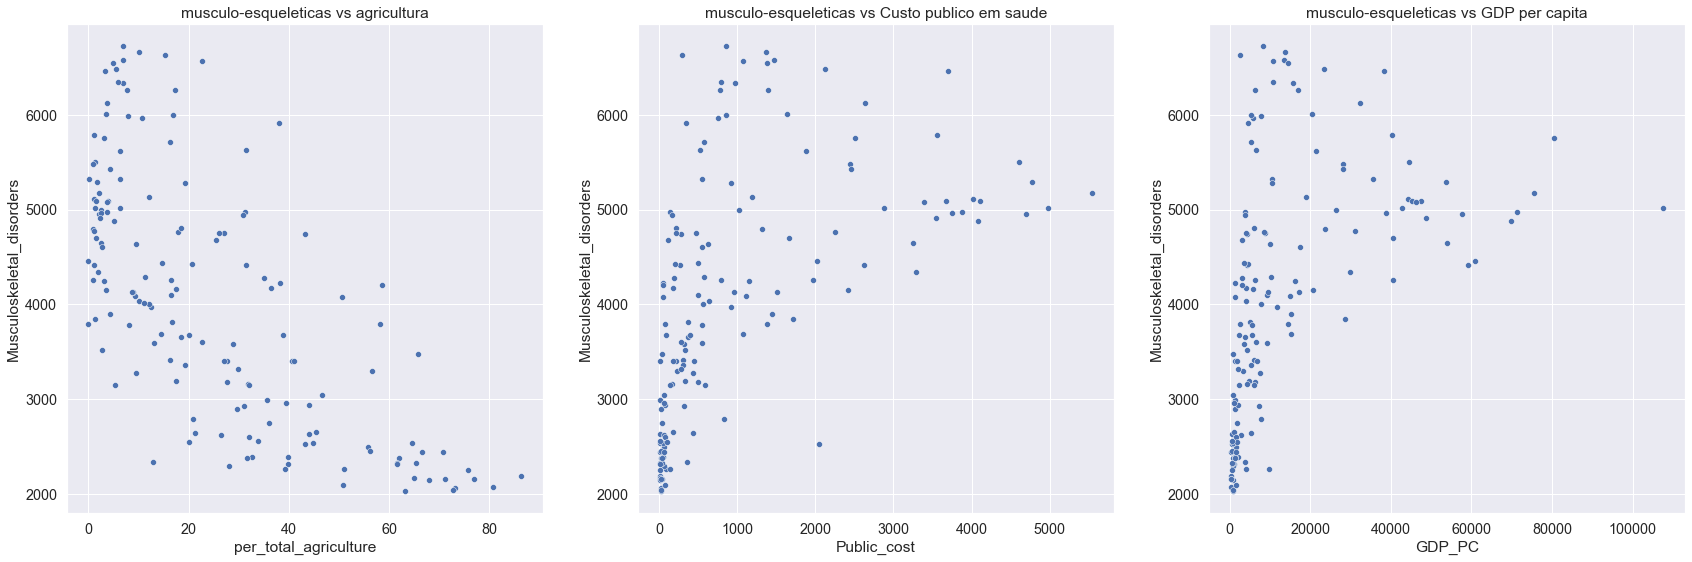

In [141]:

fig, axes = plt.subplots(1, 3, figsize=(29, 9))

sns.scatterplot(data=df_17, x='per_total_agriculture',y= 'Musculoskeletal_disorders', ax=axes[0]).set_title('musculo-esqueleticas vs agricultura')
sns.scatterplot(data=df_17, x='Public_cost',y= 'Musculoskeletal_disorders', ax=axes[1]).set_title('musculo-esqueleticas vs Custo publico em saude')
sns.scatterplot(data=df_17, x='GDP_PC',y= 'Musculoskeletal_disorders', ax=axes[2]).set_title('musculo-esqueleticas vs GDP per capita')

plt.show()


* Countries with higher incidence of Musculoskeletical diseases are the ones that have:
1. smaller agriculture sector share of employees
2. Spend more in public health costs
3. Higher GDP_PC (more developped countries might mean less agriculture)

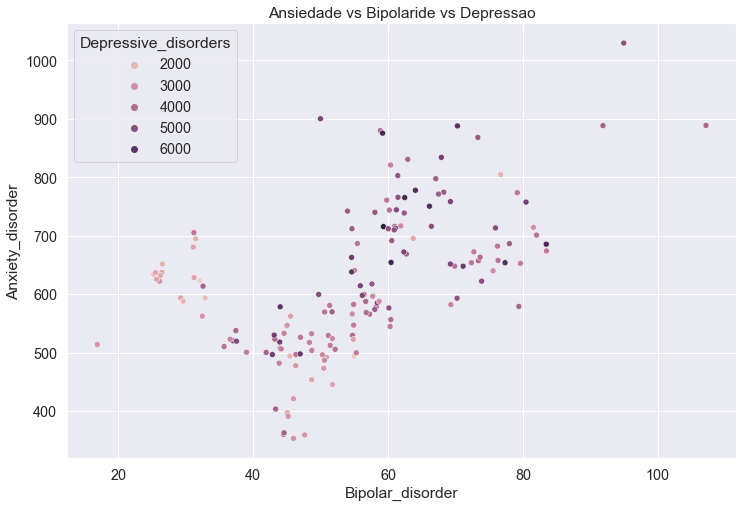

In [142]:
plt.figure(figsize=(12,8))

sns.scatterplot(data=df_17, x='Bipolar_disorder',y= 'Anxiety_disorder', hue = 'Depressive_disorders')\
.set_title('Ansiedade vs Bipolaride vs Depressao')
                
plt.show()

* Countries with higher incidence of Bipolar disorders are also the ones with higher incidence of Anxiety Disorders. Since these are both work related menatal diseases, we are going to group them into a single "mental disorder" category along with depression disorders (which has a positive correlation - although of smaller magnitude with the previous ones)

### Feature engineering

#### Feature Engineering steps:

1. Group all mental diseases (incidences per 100000 pp) in a single variable:
    * __mental_disorders = anxiety_disorder + bipolar_disorder + depressive_disorder__
2. Group Public_cost and Private_Cost in a single variable:
    * __total_health_cost = Private_cost + Public_cost__
4. the unemployment rate is a percentage over the total labor force. If we multiply it by the percentage of labor force over the whole population, we get the unemployment rate per Capita (__Unemp_PC__)
5. The variable __Weekly_work_hours__ is the complete amount of hours worked by employed persons on average per country. If we divide it by the number of employed persons, we get the average amount of hours worked per person (__Week_hours_PC__)

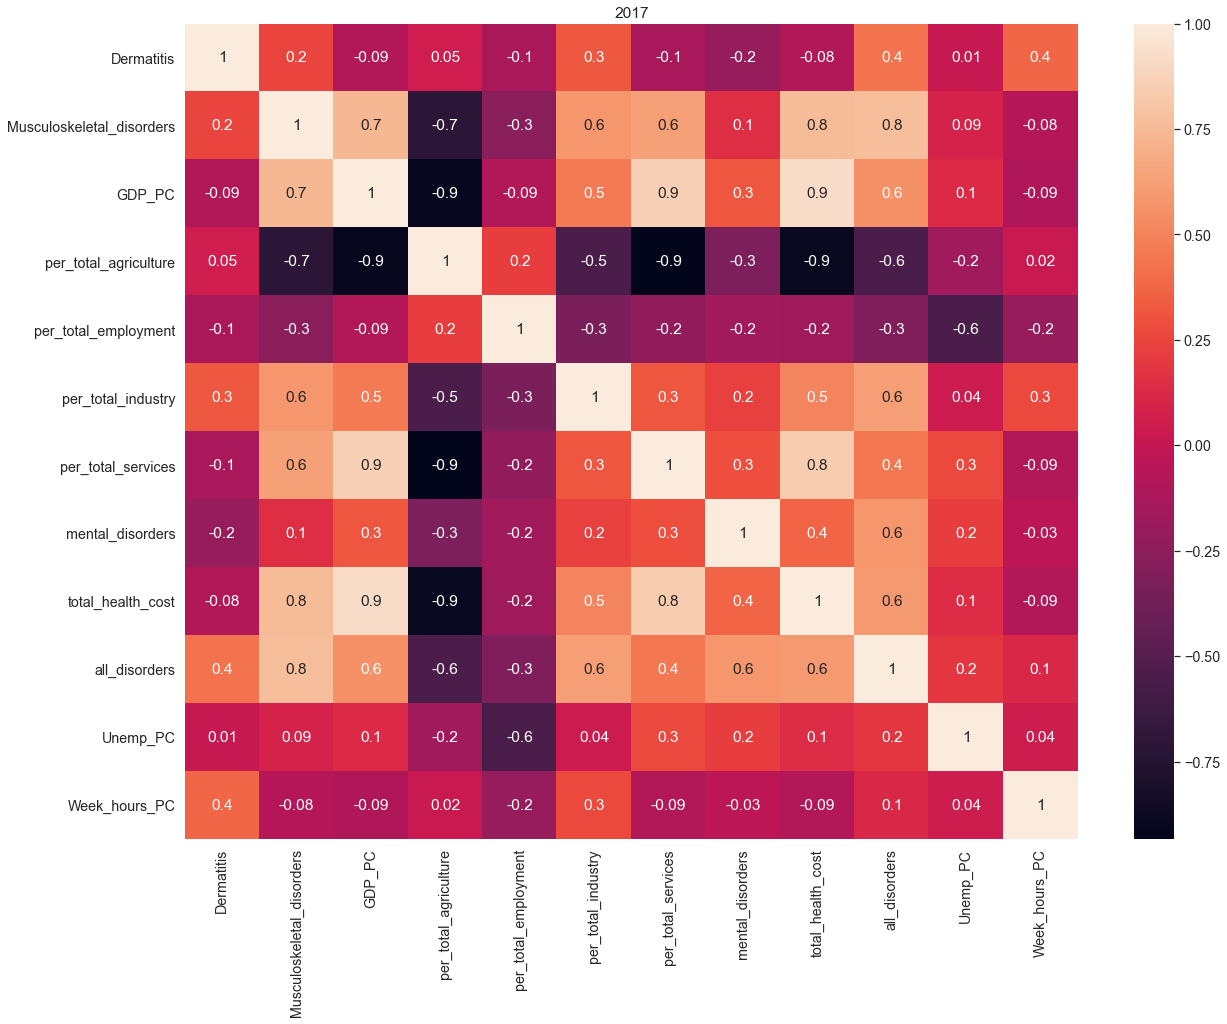

In [143]:
df_17_feat = feature_df(df_17,'2017')

### Exploration with new features

* __all_disorders__(total incidence of work related disorders) shows:
    1. Some correlation with the __GDP_PC__ (0.6) -> Countries with higher GDP tend to have more work related disorders.
    2. Some correlation with __total_health_cost__ (0.6) --> Countries with higher incidence on work related disorders tend to spend more money in health (these are also countries that tend to have higher GDP and therefore more developped)
    3. Some correlation with __per_total_industry__ (0.6) --> Countries with higher share in industry tend to have more work related disorders and less __per_total_agriculture__ (-0.6)
    
* __Week_hours_PC__ (average amount of hours worked per an employed person) shows:
    1. almost unexisting correlation with all variables except with Dermatitis (but still low correlation = 0.4)
    

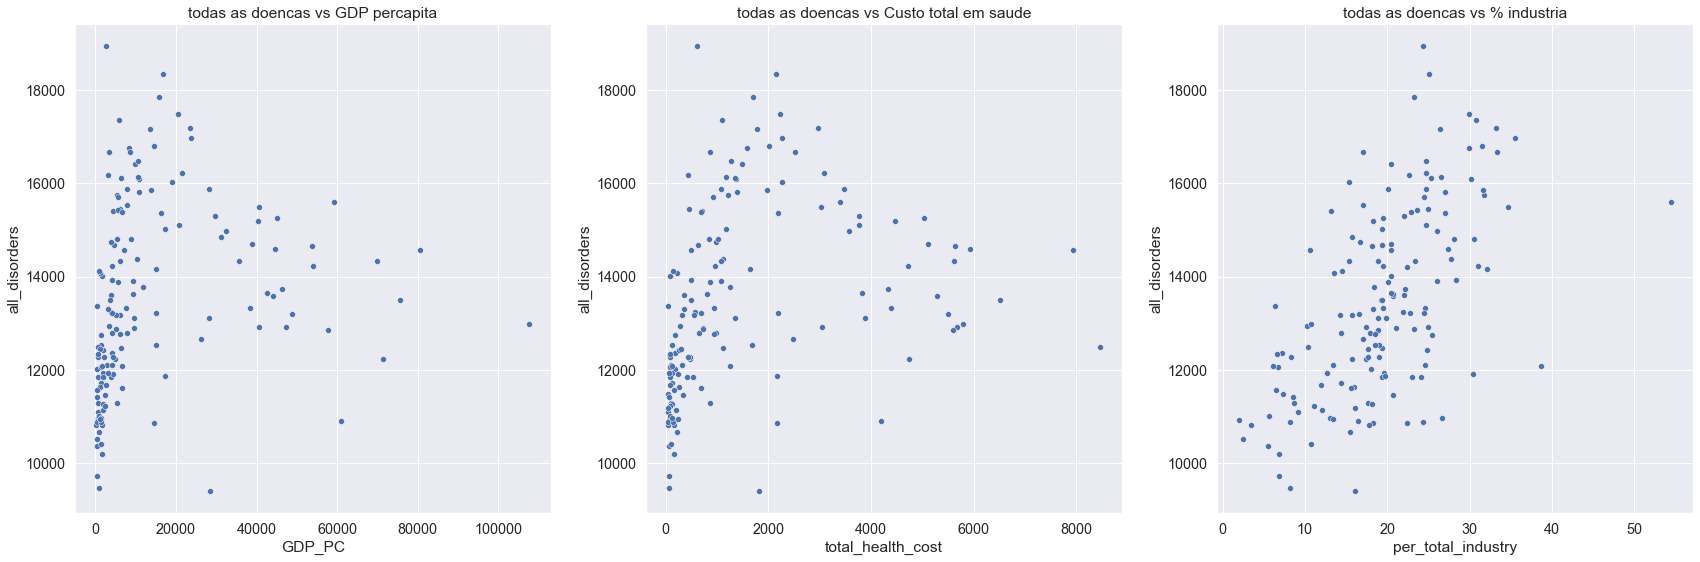

In [144]:

fig, axes = plt.subplots(1, 3, figsize=(29, 9))

sns.scatterplot(data=df_17_feat, x='GDP_PC',y= 'all_disorders', ax=axes[0]).set_title('todas as doencas vs GDP percapita')
sns.scatterplot(data=df_17_feat, x='total_health_cost',y= 'all_disorders', ax=axes[1]).set_title('todas as doencas vs Custo total em saude')
sns.scatterplot(data=df_17_feat, x='per_total_industry',y= 'all_disorders', ax=axes[2]).set_title('todas as doencas vs % industria')

plt.show()



In [147]:
df_17_feat.describe().T

,count,mean,std,min,25%,50%,75%,max
Dermatitis,157.0,4768.037525,844.724435,2755.356948,4441.318473,4877.088127,5236.099278,6626.683024
Musculoskeletal_disorders,157.0,4039.164143,1317.712702,2032.008510,2898.477911,4077.581955,4977.676623,6725.235781
GDP_PC,154.0,14207.364795,19318.796434,292.997631,1862.066374,5759.222785,16723.603844,107627.151007
per_total_agriculture,157.0,24.982102,22.223413,0.060000,5.560000,18.480000,38.759998,86.309998
per_total_employment,157.0,57.914522,11.509101,33.189999,49.599998,58.250000,65.040001,86.709999
per_total_industry,157.0,19.492611,7.898400,1.970000,15.410000,19.379999,24.540001,54.509998
per_total_services,157.0,55.526624,17.969138,10.220000,42.810001,58.799999,69.830002,87.849998
mental_disorders,157.0,4652.974367,1224.596879,2011.980909,3787.684519,4546.854334,5510.683400,7769.331191
total_health_cost,151.0,1529.857132,1827.833980,37.519101,186.617944,837.768982,2169.380463,8466.585693
all_disorders,157.0,13460.176035,2022.573882,9399.809067,11917.457008,13208.057032,14987.158698,18944.856987


### Missing Values
(Using the Gradient Boosting)

In [145]:
pd.DataFrame({'#NA: 2017': df_17_feat.isna().sum()})

,#NA: 2017
Dermatitis,0
Musculoskeletal_disorders,0
GDP_PC,3
per_total_agriculture,0
per_total_employment,0
per_total_industry,0
per_total_services,0
mental_disorders,0
total_health_cost,6
all_disorders,0


In [146]:
df_17_feat.loc[df_17_feat.isnull().any(axis=1)]

,Dermatitis,Musculoskeletal_disorders,GDP_PC,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,mental_disorders,total_health_cost,all_disorders,Unemp_PC,Week_hours_PC
location_name,,,,,,,,,,,,
Eritrea,4679.569806,2166.618721,NaN,64.889999,74.190002,7.350000,27.750000,4631.311374,40.910640,11477.499901,0.051577,NaN
Guam,5376.262523,5321.591138,35615.804627,0.250000,60.869999,15.310000,84.440002,3642.804994,NaN,14340.658655,0.035356,42.518226
Libya,4890.627687,4164.672267,5756.698450,17.580000,40.450001,23.620001,58.799999,6382.385393,NaN,15437.685347,0.092492,43.942724
Montenegro,5625.437399,5989.258728,7784.087912,7.940000,44.759998,17.080000,74.980003,3930.535277,NaN,15545.231405,0.085717,42.917924
Puerto Rico,5640.453543,4770.363208,31108.752751,1.130000,36.099998,15.680000,83.190002,4434.755309,NaN,14845.572060,0.043708,38.002861
Somalia,4348.425869,2072.495370,309.055355,80.690002,41.310001,2.460000,16.840000,4097.692861,NaN,10518.614101,0.061845,36.250964
South Sudan,4441.318473,2314.572942,NaN,61.660000,63.590000,16.080000,22.270000,4418.141543,47.142034,11174.032958,0.088619,36.192864
Syrian Arab Republic,4675.800606,4011.530808,NaN,11.220000,40.500000,22.420000,66.360001,5510.683400,NaN,14198.014814,0.036802,42.196742


In [148]:
df_17_gb = (
    df_17_feat
    .pipe(predict_missing, 'total_health_cost')
    .pipe(predict_missing, 'GDP_PC')
    .pipe(predict_missing, 'Week_hours_PC')
)

In [150]:
df_17_gb.loc[df_17_feat.isnull().any(axis=1)]
# Gradient Boosting imputed a negative total_health_cost value for Somalia, which should be corrected.
#To simplify the analysis, this line will be removed, along with outliers

,Dermatitis,Musculoskeletal_disorders,GDP_PC,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,mental_disorders,total_health_cost,all_disorders,Unemp_PC,Week_hours_PC
location_name,,,,,,,,,,,,
Eritrea,4679.569806,2166.618721,1116.161288,64.889999,74.190002,7.350000,27.750000,4631.311374,40.910640,11477.499901,0.051577,32.846900
Guam,5376.262523,5321.591138,35615.804627,0.250000,60.869999,15.310000,84.440002,3642.804994,4027.872249,14340.658655,0.035356,42.518226
Libya,4890.627687,4164.672267,5756.698450,17.580000,40.450001,23.620001,58.799999,6382.385393,658.580068,15437.685347,0.092492,43.942724
Montenegro,5625.437399,5989.258728,7784.087912,7.940000,44.759998,17.080000,74.980003,3930.535277,1488.777693,15545.231405,0.085717,42.917924
Puerto Rico,5640.453543,4770.363208,31108.752751,1.130000,36.099998,15.680000,83.190002,4434.755309,2962.644691,14845.572060,0.043708,38.002861
Somalia,4348.425869,2072.495370,309.055355,80.690002,41.310001,2.460000,16.840000,4097.692861,-27.362082,10518.614101,0.061845,36.250964
South Sudan,4441.318473,2314.572942,871.043129,61.660000,63.590000,16.080000,22.270000,4418.141543,47.142034,11174.032958,0.088619,36.192864
Syrian Arab Republic,4675.800606,4011.530808,7126.010335,11.220000,40.500000,22.420000,66.360001,5510.683400,1103.179112,14198.014814,0.036802,42.196742


### 1. Remove Outliers

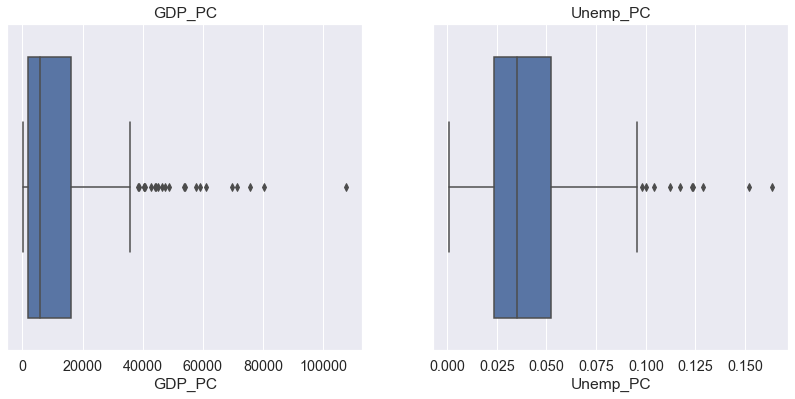

,skew,kurt
Dermatitis,-0.467853,-0.241363
Musculoskeletal_disorders,0.229870,-0.958559
GDP_PC,2.132565,4.813676
per_total_agriculture,0.849607,-0.275752
per_total_employment,0.155255,-0.351983
per_total_industry,0.433400,1.693261
per_total_services,-0.411677,-0.691903
mental_disorders,0.251585,-0.468637
total_health_cost,1.573166,1.920470
all_disorders,0.326363,-0.580497


In [156]:
eval_outliers(df_17_gb,['GDP_PC','Unemp_PC'])

In [159]:
#check removal data: outliers & errors
pd.concat([df_17_gb.loc[df_17_gb.Unemp_PC > 0.14],df_17_gb.loc[df_17_gb.GDP_PC > 65000],df_17_gb.loc[df_17_gb.total_health_cost < 0]])

,Dermatitis,Musculoskeletal_disorders,GDP_PC,per_total_agriculture,per_total_employment,per_total_industry,per_total_services,mental_disorders,total_health_cost,all_disorders,Unemp_PC,Week_hours_PC
location_name,,,,,,,,,,,,
Lesotho,5074.161492,2652.758050,1150.079174,45.430000,51.450001,13.51,41.049999,6347.787924,225.718815,14074.707465,0.163650,39.593927
South Africa,5764.945270,3152.868063,6131.479450,5.280000,40.990002,23.34,71.379997,5414.936949,1068.719543,14332.750282,0.151911,42.275911
Iceland,3265.699416,4977.676623,71310.939256,3.760000,74.540001,17.48,78.760002,3984.293983,4739.734131,12227.670022,0.020999,38.747265
Ireland,3260.744705,4876.256807,69822.347085,5.050000,58.020000,18.84,76.110001,6201.472427,5616.831787,14338.473940,0.041736,35.810822
Luxembourg,3288.160994,5022.600800,107627.151007,1.390000,55.430000,10.76,87.849998,4667.434135,5789.332764,12978.195929,0.032386,37.361508
Norway,3596.558229,5178.138695,75496.754058,2.060000,60.950001,19.41,78.529999,4725.965084,6515.912048,13500.662008,0.026458,34.524246
Switzerland,3222.047159,5755.426880,80449.994513,3.110000,65.099998,20.52,76.379997,5586.305732,7928.174316,14563.779771,0.032822,36.468699
Somalia,4348.425869,2072.495370,309.055355,80.690002,41.310001,2.46,16.840000,4097.692861,-27.362082,10518.614101,0.061845,36.250964


In [164]:
index_2_remove = pd.concat([df_17_gb.loc[df_17_gb.Unemp_PC > 0.14],df_17_gb.loc[df_17_gb.GDP_PC > 65000],df_17_gb.loc[df_17_gb.total_health_cost < 0]]).index
df_17_no = df_17_gb.drop(index = list(index_2_remove))

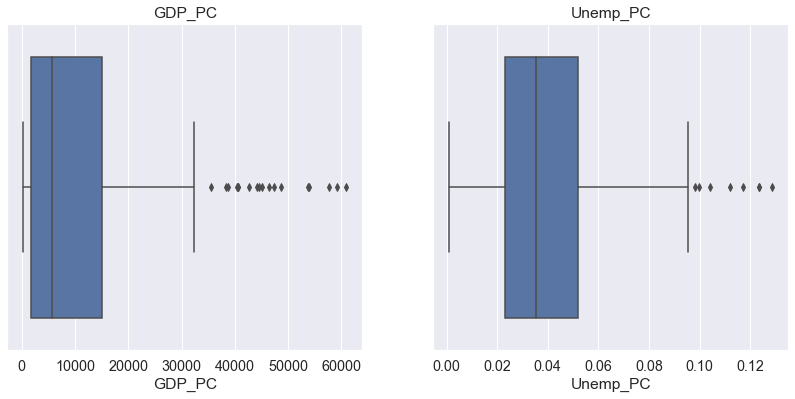

,skew,kurt
Dermatitis,-0.519303,0.027493
Musculoskeletal_disorders,0.269193,-0.919017
GDP_PC,1.680839,1.870750
per_total_agriculture,0.813176,-0.320044
per_total_employment,0.155942,-0.336038
per_total_industry,0.454994,1.667615
per_total_services,-0.397260,-0.677037
mental_disorders,0.286475,-0.456559
total_health_cost,1.638400,2.445764
all_disorders,0.336484,-0.639516


In [165]:
#Re-evaluate whiskers, skew and kurt:
eval_outliers(df_17_no,['GDP_PC','Unemp_PC'])

In [166]:
df_17_no.columns

Index(['Dermatitis', 'Musculoskeletal_disorders', 'GDP_PC',
       'per_total_agriculture', 'per_total_employment', 'per_total_industry',
       'per_total_services', 'mental_disorders', 'total_health_cost',
       'all_disorders', 'Unemp_PC', 'Week_hours_PC'],
      dtype='object')

## Cluster Analysis

### Correlation check

### Scenario 1: __For 2017__, considering the following features:

1. per_total_employment -> removed (leave only one labor overall indicator)
2. Unemp_PC
3. Week_hours_PC
4. GDP_PC (__high corr__) -> removed
5. total_health_cost (__high corr__) -> removed
6. All_disorders
7. per_total_services
8. per_total_industry -> remove (medium high correlation to services)

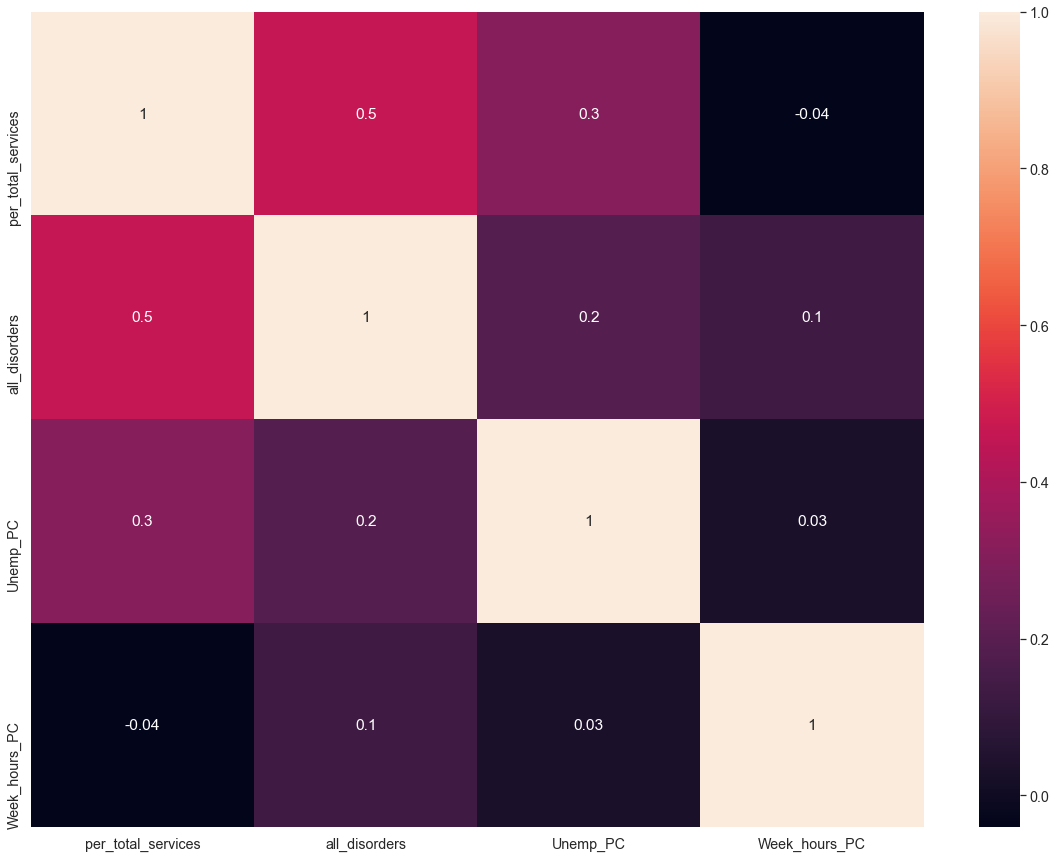

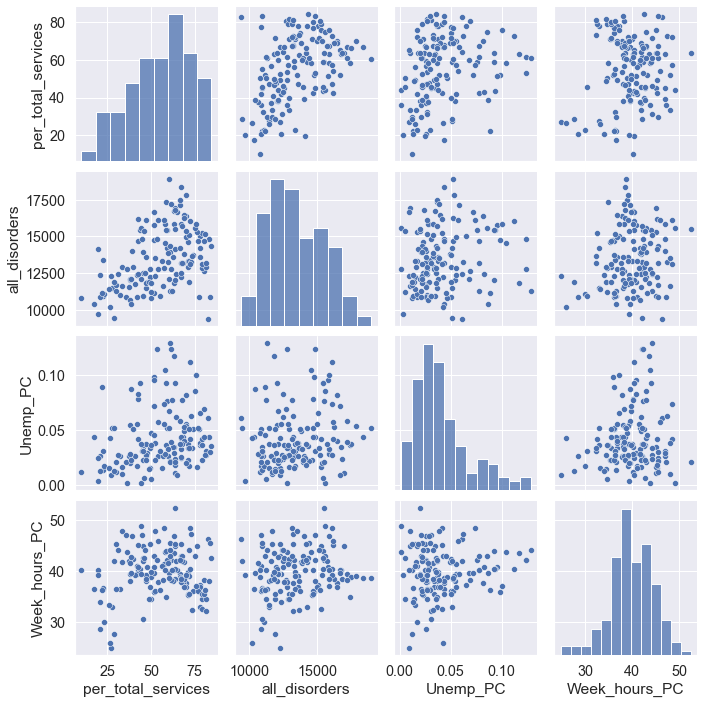

In [186]:
#cols_eval = ['per_total_employment', 'per_total_industry',
#       'per_total_services',
#       'all_disorders', 'Unemp_PC', 'Week_hours_PC']

cols_eval = ['per_total_services','all_disorders', 'Unemp_PC', 'Week_hours_PC']
             
eval_corr(df_17_no,cols_eval)

In [187]:
df_sc_1 = df_17_no[cols_eval]

### Evaluate normality of distributions

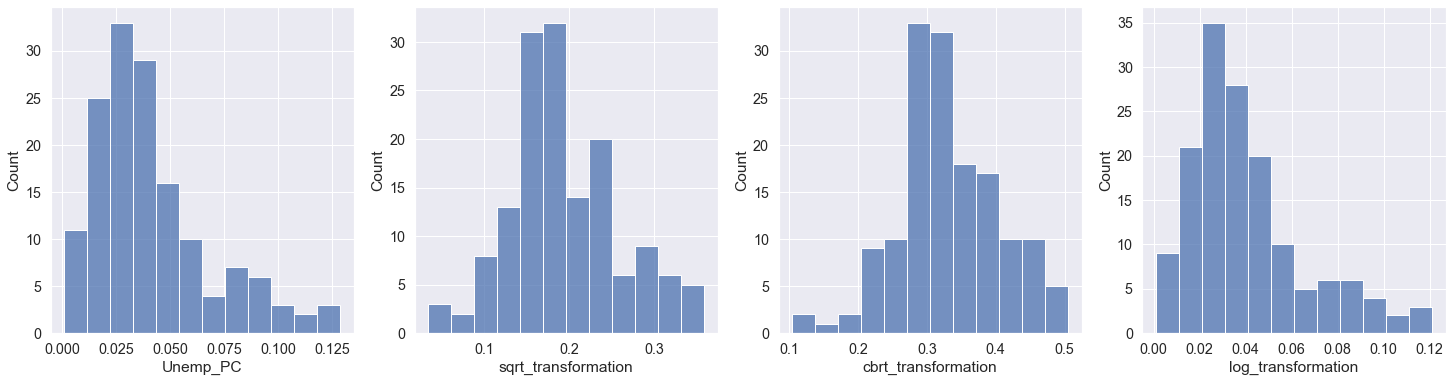

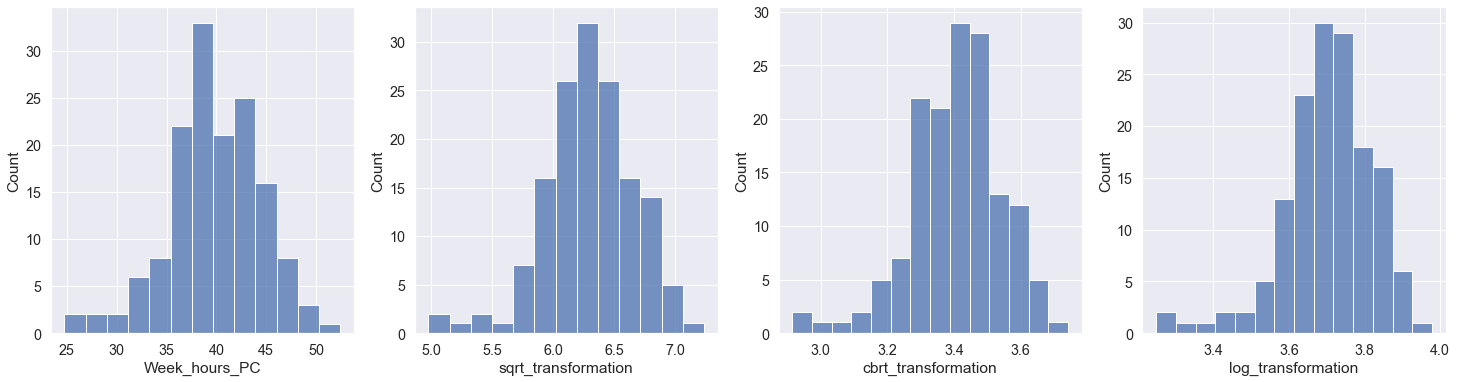

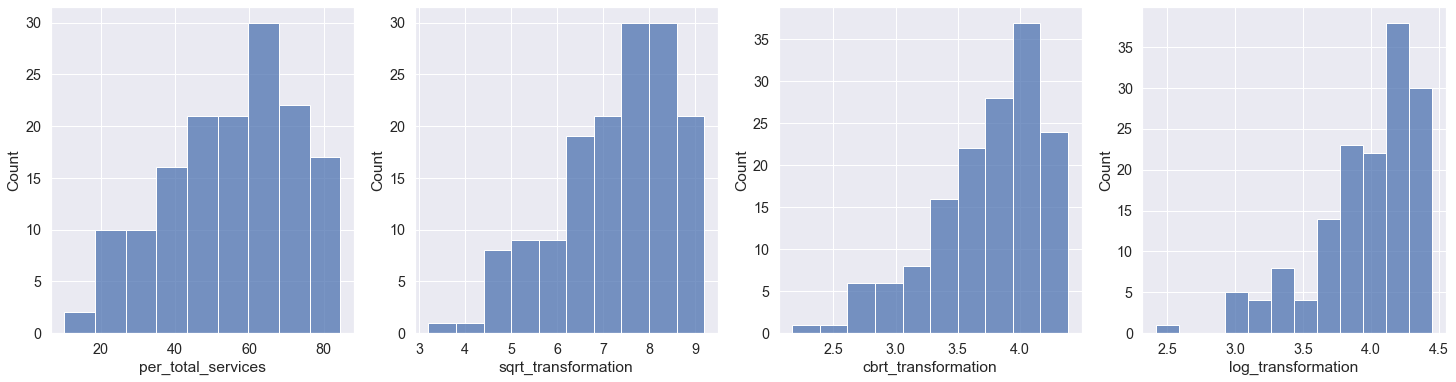

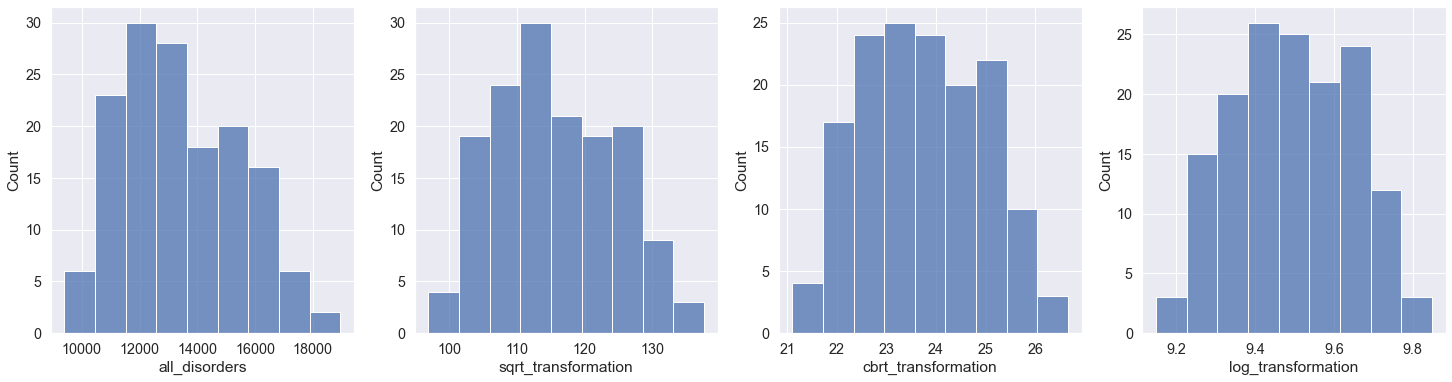

In [188]:
pt_evaluation(df_sc_1, 'Unemp_PC')
pt_evaluation(df_sc_1, 'Week_hours_PC')
pt_evaluation(df_sc_1, 'per_total_services')
pt_evaluation(df_sc_1, 'all_disorders')
#pt_evaluation(df_sc_1, 'per_total_industry')
#pt_evaluation(df_sc_1, 'per_total_employment')

In [189]:
df_sc1_t = df_sc_1[[]]
df_sc1_t = df_sc1_t.assign(Unemp_PC_cb = np.sqrt(df_sc_1['Unemp_PC']))
df_sc1_t = df_sc1_t.assign(Week_hours_PC_norm = (df_sc_1['Week_hours_PC']))
df_sc1_t = df_sc1_t.assign(per_total_services_norm = (df_sc_1['per_total_services']))
df_sc1_t = df_sc1_t.assign(all_disorders_cb = np.cbrt(df_sc_1['all_disorders']))
#df_sc1_t = df_sc1_t.assign(per_total_industry_cb = np.cbrt(df_sc_1['per_total_industry']))
#df_sc1_t = df_sc1_t.assign(per_total_employment_norm = (df_sc_1['per_total_employment']))

<AxesSubplot:>

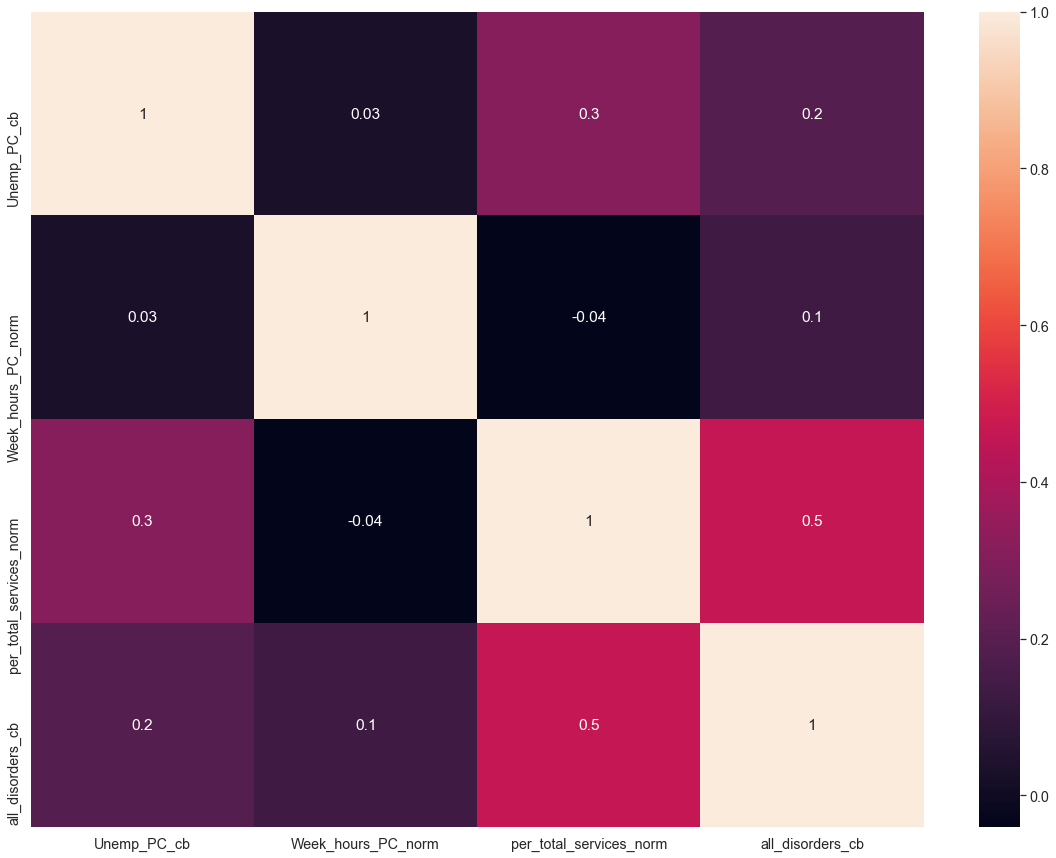

In [190]:
sns.set(font_scale=1.3)
df_corr = df_sc1_t.corr(method = 'spearman')
figure = plt.figure(figsize=(20,15))
sns.heatmap(df_corr, annot=True, fmt = '.1g')

In [191]:
minmax = MinMaxScaler()
minmax_sc1 = pd.DataFrame(minmax.fit_transform(df_sc1_t), columns=df_sc1_t.columns)

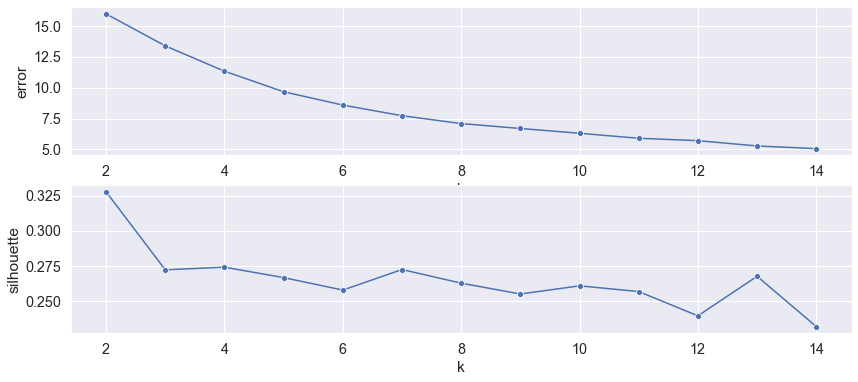

In [192]:
evaluate_number_clusters(minmax_sc1,15)

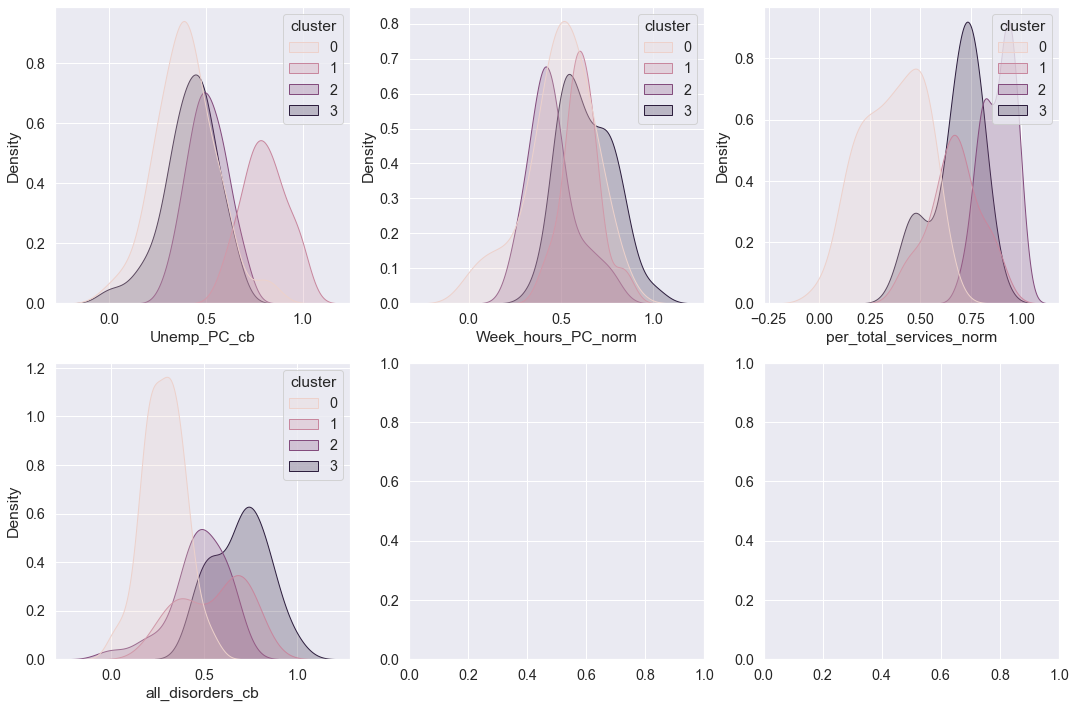

In [209]:
df1 = evaluate_cluster(minmax_sc1, df_sc_1, 4)

### Scenario 2:
Considering the following variables:


In [210]:
df1

,per_total_services,all_disorders,Unemp_PC,Week_hours_PC,labels
location_name,,,,,
Afghanistan,37.990002,12019.801306,0.054413,37.965054,0
Albania,42.540001,14681.412913,0.077770,40.176507,1
Algeria,58.849998,14235.942985,0.051360,41.701073,1
Angola,41.820000,12354.361257,0.055075,39.386274,0
Argentina,77.500000,10849.770449,0.050593,36.007197,2
...,...,...,...,...,...
Uruguay,71.519997,11864.914500,0.050662,35.518234,2
Uzbekistan,49.799999,11835.261443,0.036001,39.721078,0
Vanuatu,28.770000,11920.962552,0.012238,27.549098,0
